# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:22<00:00, 2.67KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

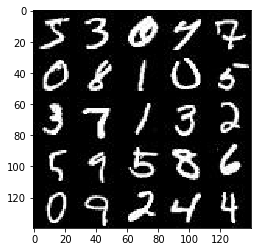

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

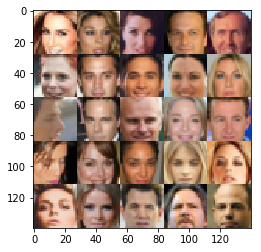

In [9]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0


//anaconda/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [11]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='inputs_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name = 'inputs_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return (inputs_real, inputs_z, learning_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [55]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Hidden layer
        # Input layer is 28x28x3
        alpha = 0.01
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
                
        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [56]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        alpha = 0.01
        h1 = tf.layers.dense(z, out_channel_dim, activation=None)
        # First fully connected layer
        x1 = tf.layers.dense(z, 4*4*256)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x256 now
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 4, strides=1, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x128 now
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x64 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [57]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    # Generator network here
    g_model = generator(input_z, out_channel_dim, is_train=True)
    # g_model is the generator output

    # Disriminator network here
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    # Calculate losses
    smooth = 0.1
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                                        labels=tf.ones_like(d_logits_real)*(1-smooth)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                        labels=tf.zeros_like(d_logits_real)))
    
    d_loss = d_loss_real + d_loss_fake

    g_loss = tf.reduce_mean(
                 tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                         labels=tf.ones_like(d_logits_fake)))
    
    return (d_loss, g_loss)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [58]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=g_vars)
    
    return (d_train_opt, g_train_opt)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [59]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [65]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    #model_inputs(image_width, image_height, image_channels, z_dim):
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    i = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                i += 1
                # TODO: Train Model
                batch_images = batch_images * 2.0
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, lr:learning_rate})
                
                
                if i % 100 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                if i % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{} - Batch {}/{}: ".format(epoch_i+1, epoch_count, i, data_shape[0]//batch_size),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))    


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

In [66]:
mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
print(mnist_dataset.shape)


(60000, 28, 28, 1)


Epoch 1/2 - Batch 10/1875:  Discriminator Loss: 0.7941... Generator Loss: 1.5033
Epoch 1/2 - Batch 20/1875:  Discriminator Loss: 0.7323... Generator Loss: 1.3747
Epoch 1/2 - Batch 30/1875:  Discriminator Loss: 0.6041... Generator Loss: 2.7618
Epoch 1/2 - Batch 40/1875:  Discriminator Loss: 0.4533... Generator Loss: 5.1521
Epoch 1/2 - Batch 50/1875:  Discriminator Loss: 0.4607... Generator Loss: 3.1602
Epoch 1/2 - Batch 60/1875:  Discriminator Loss: 0.4760... Generator Loss: 3.8227
Epoch 1/2 - Batch 70/1875:  Discriminator Loss: 0.4043... Generator Loss: 5.4979
Epoch 1/2 - Batch 80/1875:  Discriminator Loss: 0.3986... Generator Loss: 4.3136
Epoch 1/2 - Batch 90/1875:  Discriminator Loss: 0.3879... Generator Loss: 4.4412


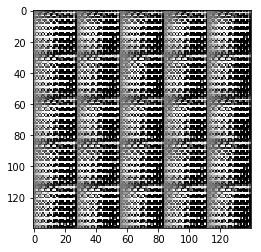

Epoch 1/2 - Batch 100/1875:  Discriminator Loss: 0.3688... Generator Loss: 4.2310
Epoch 1/2 - Batch 110/1875:  Discriminator Loss: 0.3465... Generator Loss: 6.9343
Epoch 1/2 - Batch 120/1875:  Discriminator Loss: 0.3615... Generator Loss: 4.6941
Epoch 1/2 - Batch 130/1875:  Discriminator Loss: 0.3376... Generator Loss: 7.4472
Epoch 1/2 - Batch 140/1875:  Discriminator Loss: 0.3400... Generator Loss: 7.0231
Epoch 1/2 - Batch 150/1875:  Discriminator Loss: 0.3375... Generator Loss: 5.3727
Epoch 1/2 - Batch 160/1875:  Discriminator Loss: 0.3455... Generator Loss: 4.5885
Epoch 1/2 - Batch 170/1875:  Discriminator Loss: 0.3673... Generator Loss: 4.2878
Epoch 1/2 - Batch 180/1875:  Discriminator Loss: 0.3405... Generator Loss: 7.1387
Epoch 1/2 - Batch 190/1875:  Discriminator Loss: 0.3695... Generator Loss: 4.0525


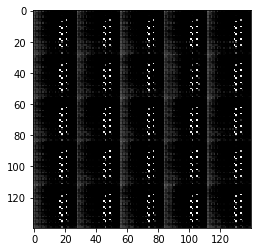

Epoch 1/2 - Batch 200/1875:  Discriminator Loss: 0.3511... Generator Loss: 5.8244
Epoch 1/2 - Batch 210/1875:  Discriminator Loss: 0.3565... Generator Loss: 5.8210
Epoch 1/2 - Batch 220/1875:  Discriminator Loss: 0.3410... Generator Loss: 6.4549
Epoch 1/2 - Batch 230/1875:  Discriminator Loss: 0.3436... Generator Loss: 5.9410
Epoch 1/2 - Batch 240/1875:  Discriminator Loss: 0.3524... Generator Loss: 5.0169
Epoch 1/2 - Batch 250/1875:  Discriminator Loss: 0.3412... Generator Loss: 5.9424
Epoch 1/2 - Batch 260/1875:  Discriminator Loss: 0.3466... Generator Loss: 6.2559
Epoch 1/2 - Batch 270/1875:  Discriminator Loss: 0.3398... Generator Loss: 6.2302
Epoch 1/2 - Batch 280/1875:  Discriminator Loss: 0.3584... Generator Loss: 4.7575
Epoch 1/2 - Batch 290/1875:  Discriminator Loss: 0.3706... Generator Loss: 6.3022


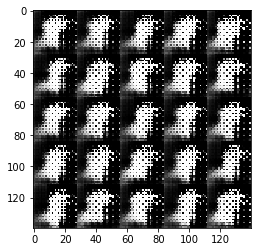

Epoch 1/2 - Batch 300/1875:  Discriminator Loss: 0.3491... Generator Loss: 5.2777
Epoch 1/2 - Batch 310/1875:  Discriminator Loss: 0.3685... Generator Loss: 5.2395
Epoch 1/2 - Batch 320/1875:  Discriminator Loss: 0.3467... Generator Loss: 4.8984
Epoch 1/2 - Batch 330/1875:  Discriminator Loss: 0.3538... Generator Loss: 4.7882
Epoch 1/2 - Batch 340/1875:  Discriminator Loss: 0.3374... Generator Loss: 5.9765
Epoch 1/2 - Batch 350/1875:  Discriminator Loss: 0.3782... Generator Loss: 4.7875
Epoch 1/2 - Batch 360/1875:  Discriminator Loss: 0.3570... Generator Loss: 5.4671
Epoch 1/2 - Batch 370/1875:  Discriminator Loss: 0.3456... Generator Loss: 6.9913
Epoch 1/2 - Batch 380/1875:  Discriminator Loss: 0.3429... Generator Loss: 5.1202
Epoch 1/2 - Batch 390/1875:  Discriminator Loss: 0.3380... Generator Loss: 6.0836


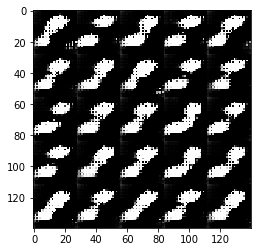

Epoch 1/2 - Batch 400/1875:  Discriminator Loss: 0.3327... Generator Loss: 6.0798
Epoch 1/2 - Batch 410/1875:  Discriminator Loss: 0.3441... Generator Loss: 4.5341
Epoch 1/2 - Batch 420/1875:  Discriminator Loss: 0.3506... Generator Loss: 6.6932
Epoch 1/2 - Batch 430/1875:  Discriminator Loss: 0.3468... Generator Loss: 5.5509
Epoch 1/2 - Batch 440/1875:  Discriminator Loss: 0.3802... Generator Loss: 4.5276
Epoch 1/2 - Batch 450/1875:  Discriminator Loss: 0.3782... Generator Loss: 7.5785
Epoch 1/2 - Batch 460/1875:  Discriminator Loss: 0.3390... Generator Loss: 5.4828
Epoch 1/2 - Batch 470/1875:  Discriminator Loss: 0.3532... Generator Loss: 5.3027
Epoch 1/2 - Batch 480/1875:  Discriminator Loss: 0.3630... Generator Loss: 6.5875
Epoch 1/2 - Batch 490/1875:  Discriminator Loss: 0.3352... Generator Loss: 5.5384


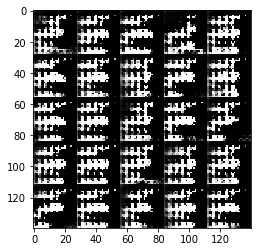

Epoch 1/2 - Batch 500/1875:  Discriminator Loss: 0.3348... Generator Loss: 6.1895
Epoch 1/2 - Batch 510/1875:  Discriminator Loss: 0.3566... Generator Loss: 4.9837
Epoch 1/2 - Batch 520/1875:  Discriminator Loss: 0.3854... Generator Loss: 3.6963
Epoch 1/2 - Batch 530/1875:  Discriminator Loss: 0.3691... Generator Loss: 6.7412
Epoch 1/2 - Batch 540/1875:  Discriminator Loss: 0.5357... Generator Loss: 3.8317
Epoch 1/2 - Batch 550/1875:  Discriminator Loss: 0.3944... Generator Loss: 5.5762
Epoch 1/2 - Batch 560/1875:  Discriminator Loss: 0.3775... Generator Loss: 4.0447
Epoch 1/2 - Batch 570/1875:  Discriminator Loss: 0.3675... Generator Loss: 4.7304
Epoch 1/2 - Batch 580/1875:  Discriminator Loss: 0.3608... Generator Loss: 6.3298
Epoch 1/2 - Batch 590/1875:  Discriminator Loss: 0.3647... Generator Loss: 4.5086


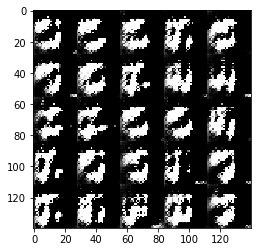

Epoch 1/2 - Batch 600/1875:  Discriminator Loss: 0.3865... Generator Loss: 3.9671
Epoch 1/2 - Batch 610/1875:  Discriminator Loss: 0.5667... Generator Loss: 7.9237
Epoch 1/2 - Batch 620/1875:  Discriminator Loss: 0.3911... Generator Loss: 4.6069
Epoch 1/2 - Batch 630/1875:  Discriminator Loss: 0.4458... Generator Loss: 3.5850
Epoch 1/2 - Batch 640/1875:  Discriminator Loss: 0.3808... Generator Loss: 6.0826
Epoch 1/2 - Batch 650/1875:  Discriminator Loss: 0.4246... Generator Loss: 4.0979
Epoch 1/2 - Batch 660/1875:  Discriminator Loss: 0.3827... Generator Loss: 5.0977
Epoch 1/2 - Batch 670/1875:  Discriminator Loss: 0.4530... Generator Loss: 3.9925
Epoch 1/2 - Batch 680/1875:  Discriminator Loss: 0.3617... Generator Loss: 6.2310
Epoch 1/2 - Batch 690/1875:  Discriminator Loss: 0.4303... Generator Loss: 4.0387


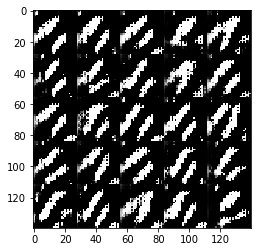

Epoch 1/2 - Batch 700/1875:  Discriminator Loss: 0.3936... Generator Loss: 4.9478
Epoch 1/2 - Batch 710/1875:  Discriminator Loss: 0.3641... Generator Loss: 5.9550
Epoch 1/2 - Batch 720/1875:  Discriminator Loss: 0.3684... Generator Loss: 5.9103
Epoch 1/2 - Batch 730/1875:  Discriminator Loss: 0.4854... Generator Loss: 4.2239
Epoch 1/2 - Batch 740/1875:  Discriminator Loss: 0.3956... Generator Loss: 4.5066
Epoch 1/2 - Batch 750/1875:  Discriminator Loss: 0.3504... Generator Loss: 6.8728
Epoch 1/2 - Batch 760/1875:  Discriminator Loss: 0.3646... Generator Loss: 4.4246
Epoch 1/2 - Batch 770/1875:  Discriminator Loss: 0.3581... Generator Loss: 5.5110
Epoch 1/2 - Batch 780/1875:  Discriminator Loss: 0.3482... Generator Loss: 6.0948
Epoch 1/2 - Batch 790/1875:  Discriminator Loss: 0.3865... Generator Loss: 4.1352


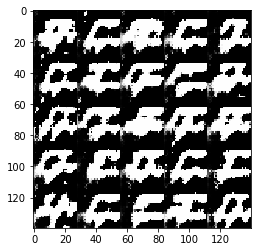

Epoch 1/2 - Batch 800/1875:  Discriminator Loss: 0.3982... Generator Loss: 3.4275
Epoch 1/2 - Batch 810/1875:  Discriminator Loss: 0.3778... Generator Loss: 5.9884
Epoch 1/2 - Batch 820/1875:  Discriminator Loss: 0.4157... Generator Loss: 3.1784
Epoch 1/2 - Batch 830/1875:  Discriminator Loss: 0.5206... Generator Loss: 7.8629
Epoch 1/2 - Batch 840/1875:  Discriminator Loss: 0.5389... Generator Loss: 6.7447
Epoch 1/2 - Batch 850/1875:  Discriminator Loss: 0.3795... Generator Loss: 8.1958
Epoch 1/2 - Batch 860/1875:  Discriminator Loss: 0.4320... Generator Loss: 4.5527
Epoch 1/2 - Batch 870/1875:  Discriminator Loss: 0.4029... Generator Loss: 7.9223
Epoch 1/2 - Batch 880/1875:  Discriminator Loss: 0.4408... Generator Loss: 3.0093
Epoch 1/2 - Batch 890/1875:  Discriminator Loss: 0.3898... Generator Loss: 4.3430


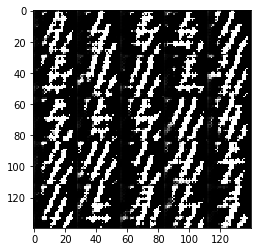

Epoch 1/2 - Batch 900/1875:  Discriminator Loss: 0.3587... Generator Loss: 5.6126
Epoch 1/2 - Batch 910/1875:  Discriminator Loss: 0.4143... Generator Loss: 8.2821
Epoch 1/2 - Batch 920/1875:  Discriminator Loss: 0.3721... Generator Loss: 5.2685
Epoch 1/2 - Batch 930/1875:  Discriminator Loss: 0.3645... Generator Loss: 6.0245
Epoch 1/2 - Batch 940/1875:  Discriminator Loss: 0.3904... Generator Loss: 3.8372
Epoch 1/2 - Batch 950/1875:  Discriminator Loss: 0.3577... Generator Loss: 5.8323
Epoch 1/2 - Batch 960/1875:  Discriminator Loss: 0.3627... Generator Loss: 6.8564
Epoch 1/2 - Batch 970/1875:  Discriminator Loss: 0.3476... Generator Loss: 7.3480
Epoch 1/2 - Batch 980/1875:  Discriminator Loss: 0.4420... Generator Loss: 3.9071
Epoch 1/2 - Batch 990/1875:  Discriminator Loss: 0.3348... Generator Loss: 6.7399


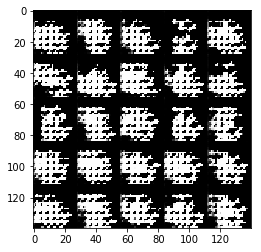

Epoch 1/2 - Batch 1000/1875:  Discriminator Loss: 0.3942... Generator Loss: 3.6159
Epoch 1/2 - Batch 1010/1875:  Discriminator Loss: 0.5436... Generator Loss: 2.5806
Epoch 1/2 - Batch 1020/1875:  Discriminator Loss: 0.3384... Generator Loss: 11.5037
Epoch 1/2 - Batch 1030/1875:  Discriminator Loss: 0.4108... Generator Loss: 3.9452
Epoch 1/2 - Batch 1040/1875:  Discriminator Loss: 0.3723... Generator Loss: 11.8726
Epoch 1/2 - Batch 1050/1875:  Discriminator Loss: 0.3602... Generator Loss: 7.0658
Epoch 1/2 - Batch 1060/1875:  Discriminator Loss: 0.3598... Generator Loss: 6.9553
Epoch 1/2 - Batch 1070/1875:  Discriminator Loss: 0.3490... Generator Loss: 8.2829
Epoch 1/2 - Batch 1080/1875:  Discriminator Loss: 0.3746... Generator Loss: 5.7616
Epoch 1/2 - Batch 1090/1875:  Discriminator Loss: 0.4518... Generator Loss: 2.8142


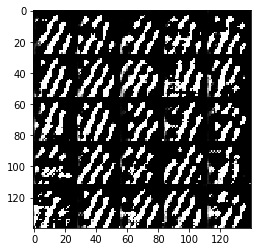

Epoch 1/2 - Batch 1100/1875:  Discriminator Loss: 0.4122... Generator Loss: 4.7402
Epoch 1/2 - Batch 1110/1875:  Discriminator Loss: 0.3767... Generator Loss: 6.2176
Epoch 1/2 - Batch 1120/1875:  Discriminator Loss: 0.5883... Generator Loss: 2.4663
Epoch 1/2 - Batch 1130/1875:  Discriminator Loss: 0.4513... Generator Loss: 7.0760
Epoch 1/2 - Batch 1140/1875:  Discriminator Loss: 0.4286... Generator Loss: 4.5340
Epoch 1/2 - Batch 1150/1875:  Discriminator Loss: 0.4229... Generator Loss: 3.6849
Epoch 1/2 - Batch 1160/1875:  Discriminator Loss: 0.3632... Generator Loss: 5.1209
Epoch 1/2 - Batch 1170/1875:  Discriminator Loss: 0.3612... Generator Loss: 4.1844
Epoch 1/2 - Batch 1180/1875:  Discriminator Loss: 0.3432... Generator Loss: 6.7260
Epoch 1/2 - Batch 1190/1875:  Discriminator Loss: 0.3596... Generator Loss: 4.6020


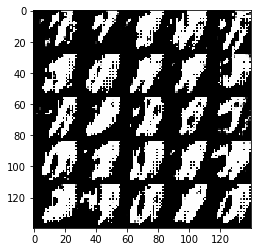

Epoch 1/2 - Batch 1200/1875:  Discriminator Loss: 0.3601... Generator Loss: 6.1175
Epoch 1/2 - Batch 1210/1875:  Discriminator Loss: 0.3423... Generator Loss: 5.4019
Epoch 1/2 - Batch 1220/1875:  Discriminator Loss: 0.3510... Generator Loss: 5.8512
Epoch 1/2 - Batch 1230/1875:  Discriminator Loss: 0.3671... Generator Loss: 4.5414
Epoch 1/2 - Batch 1240/1875:  Discriminator Loss: 0.3590... Generator Loss: 4.3040
Epoch 1/2 - Batch 1250/1875:  Discriminator Loss: 0.4935... Generator Loss: 3.0685
Epoch 1/2 - Batch 1260/1875:  Discriminator Loss: 0.3735... Generator Loss: 4.9871
Epoch 1/2 - Batch 1270/1875:  Discriminator Loss: 0.3855... Generator Loss: 4.2369
Epoch 1/2 - Batch 1280/1875:  Discriminator Loss: 0.3443... Generator Loss: 5.6622
Epoch 1/2 - Batch 1290/1875:  Discriminator Loss: 0.3609... Generator Loss: 6.6207


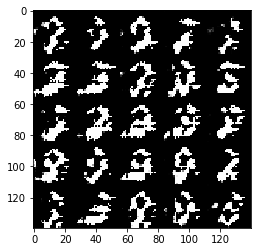

Epoch 1/2 - Batch 1300/1875:  Discriminator Loss: 0.4173... Generator Loss: 7.7358
Epoch 1/2 - Batch 1310/1875:  Discriminator Loss: 0.4093... Generator Loss: 3.5845
Epoch 1/2 - Batch 1320/1875:  Discriminator Loss: 0.4310... Generator Loss: 3.6543
Epoch 1/2 - Batch 1330/1875:  Discriminator Loss: 0.4101... Generator Loss: 4.3773
Epoch 1/2 - Batch 1340/1875:  Discriminator Loss: 0.4043... Generator Loss: 3.6488
Epoch 1/2 - Batch 1350/1875:  Discriminator Loss: 0.4097... Generator Loss: 4.8827
Epoch 1/2 - Batch 1360/1875:  Discriminator Loss: 0.3798... Generator Loss: 6.1792
Epoch 1/2 - Batch 1370/1875:  Discriminator Loss: 0.3692... Generator Loss: 4.8888
Epoch 1/2 - Batch 1380/1875:  Discriminator Loss: 0.3844... Generator Loss: 4.9898
Epoch 1/2 - Batch 1390/1875:  Discriminator Loss: 0.3670... Generator Loss: 6.7874


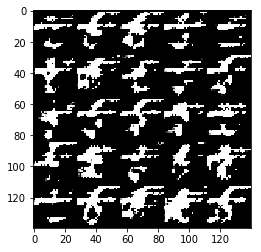

Epoch 1/2 - Batch 1400/1875:  Discriminator Loss: 0.3582... Generator Loss: 6.0912
Epoch 1/2 - Batch 1410/1875:  Discriminator Loss: 0.3617... Generator Loss: 4.9165
Epoch 1/2 - Batch 1420/1875:  Discriminator Loss: 0.4318... Generator Loss: 3.0349
Epoch 1/2 - Batch 1430/1875:  Discriminator Loss: 0.9679... Generator Loss: 1.3931
Epoch 1/2 - Batch 1440/1875:  Discriminator Loss: 0.5910... Generator Loss: 3.6718
Epoch 1/2 - Batch 1450/1875:  Discriminator Loss: 0.4939... Generator Loss: 3.0224
Epoch 1/2 - Batch 1460/1875:  Discriminator Loss: 0.4401... Generator Loss: 5.4194
Epoch 1/2 - Batch 1470/1875:  Discriminator Loss: 0.3710... Generator Loss: 4.7037
Epoch 1/2 - Batch 1480/1875:  Discriminator Loss: 0.3439... Generator Loss: 5.2127
Epoch 1/2 - Batch 1490/1875:  Discriminator Loss: 0.3591... Generator Loss: 4.3101


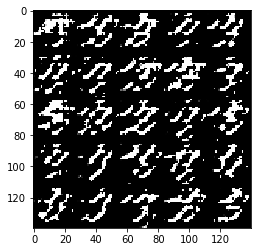

Epoch 1/2 - Batch 1500/1875:  Discriminator Loss: 0.3488... Generator Loss: 5.5252
Epoch 1/2 - Batch 1510/1875:  Discriminator Loss: 0.3919... Generator Loss: 3.4421
Epoch 1/2 - Batch 1520/1875:  Discriminator Loss: 0.4134... Generator Loss: 6.0202
Epoch 1/2 - Batch 1530/1875:  Discriminator Loss: 0.4155... Generator Loss: 7.2832
Epoch 1/2 - Batch 1540/1875:  Discriminator Loss: 0.3584... Generator Loss: 7.7242
Epoch 1/2 - Batch 1550/1875:  Discriminator Loss: 0.4274... Generator Loss: 5.8052
Epoch 1/2 - Batch 1560/1875:  Discriminator Loss: 0.4384... Generator Loss: 3.2595
Epoch 1/2 - Batch 1570/1875:  Discriminator Loss: 0.4150... Generator Loss: 5.8477
Epoch 1/2 - Batch 1580/1875:  Discriminator Loss: 0.4093... Generator Loss: 4.2164
Epoch 1/2 - Batch 1590/1875:  Discriminator Loss: 0.4273... Generator Loss: 4.0612


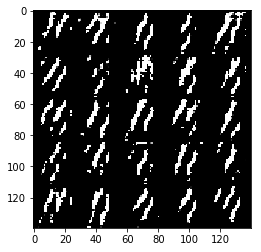

Epoch 1/2 - Batch 1600/1875:  Discriminator Loss: 0.3721... Generator Loss: 6.4158


KeyboardInterrupt: 

In [70]:
batch_size = 32
z_dim = 100
learning_rate = 0.001
beta1 = 0.9


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

In [ ]:
batch_size = None
z_dim = None
learning_rate = None
beta1 = None


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.